In [124]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ast import literal_eval
from itertools import zip_longest
import numpy as np

def plot_all(show_all=True):
    plt.figure(figsize=(10,7))
    names = ["cellulitis", "copper", "search", "uti", "overdiagnosis"]
    for name in names:
        effort_accuracy_plot(name, show_all)
    if show_all:
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.yticks(np.arange(0.2, 1.1, 0.1))
    plt.legend()
    plt.show()

def effort_accuracy_plot(name, show_all=True):
    stats_df = pd.read_csv("stats-" + name + ".csv")
    # Convert csv lists to actual lists
    stats_df.effort = stats_df.effort.apply(literal_eval)
    stats_df.accuracy = stats_df.accuracy.apply(literal_eval)

    # Find longest effort array
    effort = max(stats_df.effort, key=len)
    # Average all accuracy data points over the 10 iterations
    avg_accuracy = np.nanmean(np.array(list(zip_longest(*stats_df.accuracy, fillvalue=1)),dtype=float), axis=1).tolist()

    # Add values to show all
    if (show_all):
        effort.append(1)
        avg_accuracy.append(max(avg_accuracy))


    # Make plot look nice
    plt.xlabel("effort")
    plt.ylabel("accuracy")
    plt.plot(effort, avg_accuracy, label=name)

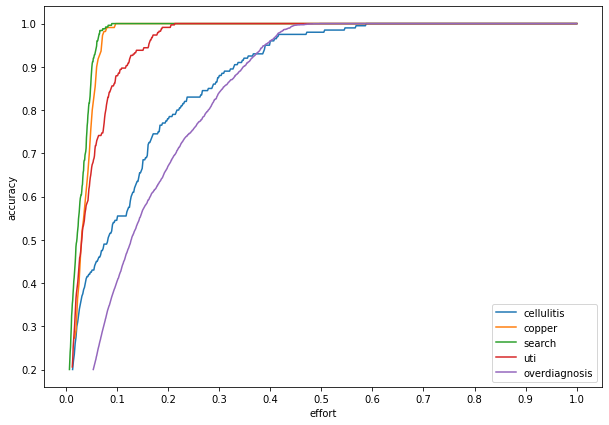

In [125]:
plot_all(True)

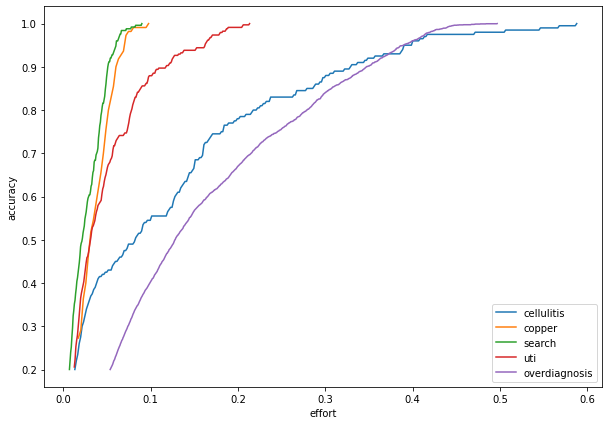

In [126]:
plot_all(False)

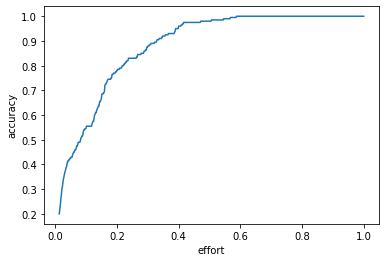

In [85]:
effort_accuracy_plot("cellulitis")

0.27272727272727265


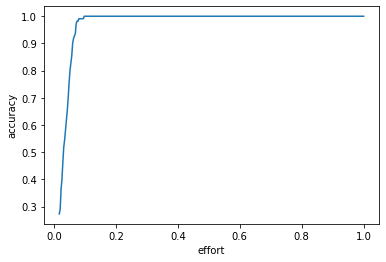

In [88]:
effort_accuracy_plot("copper")

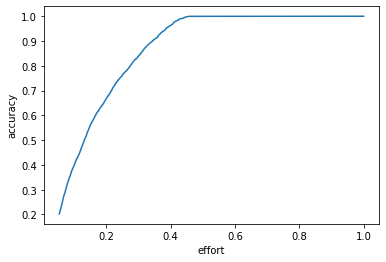

In [82]:
effort_accuracy_plot("overdiagnosis")

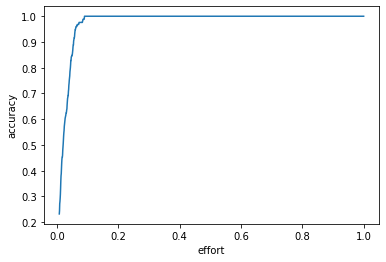

In [83]:
effort_accuracy_plot("search")

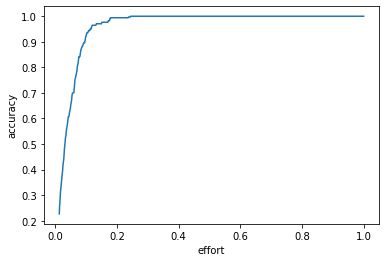

In [84]:
effort_accuracy_plot("uti")